In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")

In [3]:
columns_to_drop = ['title', 'description', 'street_address', 'suburb', 
                    'structured_features', 'video_count', 'floor_plans_count',
                   'date_listed', 'virtual_tour', 'latitude', 'longitude', 'primary_property_type']

In [4]:
target = np.array(property_df['price']) # target variable
features = np.array(property_df.drop(columns=columns_to_drop+['price']))
feature_list = list(property_df.drop(columns=columns_to_drop+['price']).columns)

In [5]:
# Taken from https://towardsdatascience.com/ai-and-real-state-renting-in-amsterdam-part-1-5fce18238dbc

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=10,random_state=30034,shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]


    # Paramets found using hyperparameter tuning (shown later in the notebook)
    rf = RandomForestRegressor(n_estimators = 400, 
                                random_state = 30034, 
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = None,
                                bootstrap=False)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

print('\nAverage accuracy:', np.mean(accuracies))

Mean Absolute Error: 121.88
Accuracy: 75.5 %.
Mean Absolute Error: 119.84
Accuracy: 81.31 %.
Mean Absolute Error: 171.01
Accuracy: 82.81 %.
Mean Absolute Error: 116.95
Accuracy: 59.27 %.
Mean Absolute Error: 184.69
Accuracy: 80.41 %.
Mean Absolute Error: 241.82
Accuracy: 74.74 %.
Mean Absolute Error: 118.68
Accuracy: 79.3 %.
Mean Absolute Error: 123.95
Accuracy: 82.58 %.
Mean Absolute Error: 128.0
Accuracy: 68.02 %.
Mean Absolute Error: 151.02
Accuracy: 68.3 %.

Average accuracy: 75.22301224170893


In [6]:
test_hyperparameters = False

if test_hyperparameters:
    from sklearn.model_selection import RandomizedSearchCV
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    random_grid
    # Use the random grid to search for best hyperparameters
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(data_train, target_train)

    print(rf_random.best_params_)

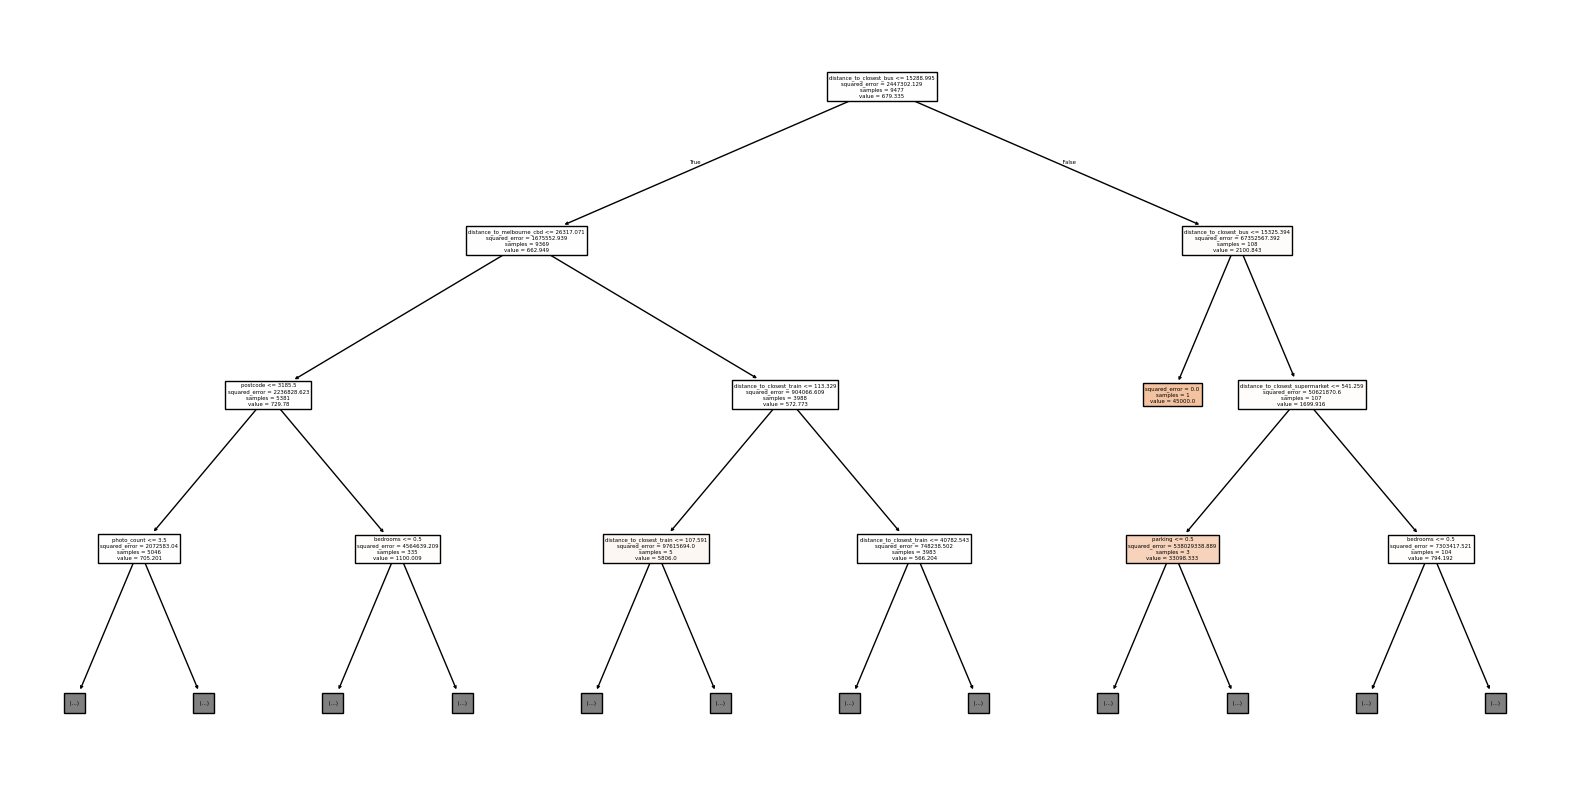

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=feature_list, filled=True, max_depth=3)
plt.savefig('../../plots/decision_tree.png')
plt.show()

In [8]:
y = rf.feature_importances_
list_y = [a for a in y if a > 0.005]
print(list_y)

list_of_index = []
for i in list_y:
    a = np.where(y==i)
    list_of_index.append(a)
print(list_of_index)
list_of_index = [0,1,2,3,4,5,6,7,8,9,10,11]

[np.float64(0.04666741032726264), np.float64(0.25457590775769284), np.float64(0.017286856506668034), np.float64(0.04657216444781947), np.float64(0.0461022699925183), np.float64(0.07937880719338423), np.float64(0.04899153058280254), np.float64(0.08541540664037726), np.float64(0.07066888195710448), np.float64(0.09676259529022158), np.float64(0.10256021673654032), np.float64(0.10501795256760839)]
[(array([0]),), (array([1]),), (array([2]),), (array([3]),), (array([4]),), (array([5]),), (array([6]),), (array([7]),), (array([8]),), (array([9]),), (array([10]),), (array([11]),)]


In [9]:
col = []
for i in feature_list:
    col.append(i)
labels = []
for i in list_of_index:
    b = col[i]
    labels.append(b)

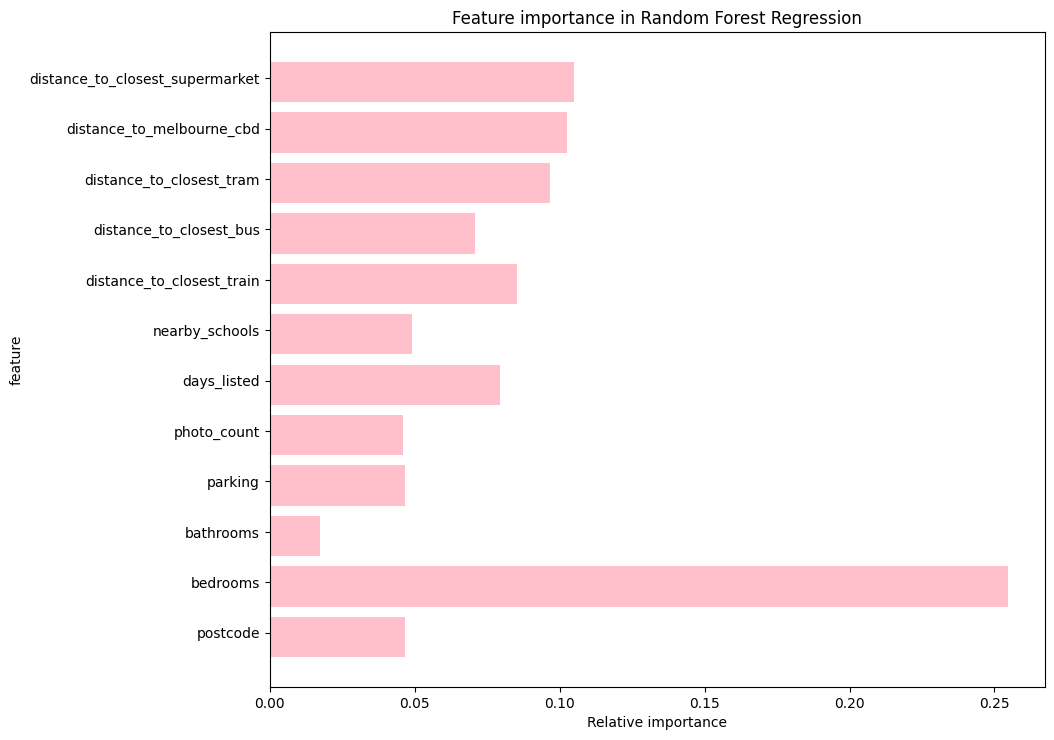

<Figure size 1000x850 with 0 Axes>

In [10]:
y = list_y
fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(y)) 
ax.barh(ind, y,width, color="pink")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(labels, minor=False)
plt.title('Feature importance in Random Forest Regression')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(10,8.5))
plt.tight_layout()
plt.savefig('../../plots/feature_importance.png')
fig.set_size_inches(10, 8.5, forward=True)

plt.show()
